In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info) 

Thu Dec 17 02:24:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.ion()   

In [4]:
path_csv = 'drive/My Drive/Genpact Project/Image.csv'
images = 'drive/My Drive/Genpact Project/coil-100'
train_data =  'drive/My Drive/Genpact Project/train.csv'
test_data =  'drive/My Drive/Genpact Project/test.csv'

In [5]:
df = pd.read_csv(path_csv)
train = pd.read_csv(train_data)
test = pd.read_csv(test_data)

In [6]:
class SiameseDataset(Dataset):
    def __init__(self, csv, root_dir, transform = None):
        self.df = pd.read_csv(csv)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_1 = Image.open(os.path.join(self.root_dir,
                                self.df.iloc[idx, 0] ))
        
        img_2= Image.open(os.path.join(self.root_dir,
                                self.df.iloc[idx, 1] ))
        
        angle = self.df.iloc[idx, 2]
        
        img_1 = img_1.convert("L")
        img_2 = img_2.convert("L")
                              
        
        
        if self.transform is not None:
            img_1 = self.transform(img_1)
            img_2 = self. transform(img_2)
            #sample = self.transform(sample)
        
        return img_1, img_2, torch.from_numpy(np.array([angle ],dtype=np.float32) )

In [7]:
if torch.cuda.is_available():
    print('Yes')

Yes


In [8]:
train_data = SiameseDataset(csv = train_data,
                  root_dir = images,
                   transform=transforms.Compose([transforms.ToTensor() ] ) 
                  ) 
train_dataloader = DataLoader(train_data, batch_size=8,
                        shuffle=True)


[[140.]
 [120.]
 [ 85.]
 [ 10.]
 [160.]
 [ 70.]
 [120.]
 [ 85.]]


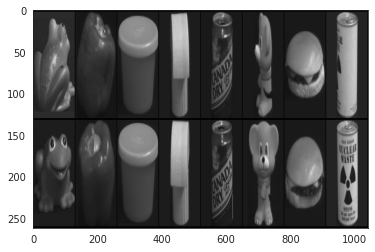

In [9]:
sns.set_style("white"); 
dataiter = iter(train_dataloader)
example_batch = next(dataiter) 
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
xx = torchvision.utils.make_grid(concatenated)
xx = xx.permute(1,2,0)
plt.imshow(xx,  aspect='auto')
print(example_batch[2].numpy()) 

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(43264, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True)
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p= 0.5),
            
            nn.Linear(64, 1)
            #nn.ReLU(inplace=True)
        )
            
    
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        out_1 = self.forward_once(input1)
        # forward pass of input 2
        out_2 = self.forward_once(input2)
        #print(out_2.shape)
        out = torch.cat((out_1, out_2), 1)
        #print(out.shape)
        out = self.fc2(out)
        
        return out

In [11]:
network = SiameseNetwork().cuda()
network

SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=43264, out_features=1024, bias=True)
    (1): Re

In [12]:
loss = nn.MSELoss()  
optimizer = optim.RMSprop(network.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9) 

In [13]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,10): 
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output = network(img0,img1)
            #print(output.shape) 
            #print(label.shape)
            loss_contrastive = torch.sqrt( loss(output,label) ) 
            loss_contrastive.backward()
            optimizer.step()
            if i %1000 == 0 :
                print("Epoch number {}\n Iteraion {}\n Current loss {}\n".format(epoch,i,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return network

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = train()
torch.save(model.state_dict(), "final_2_(RMSE).pt")
print("Model Saved Successfully")


Epoch number 0
 Iteraion 0
 Current loss 83.5495376586914

Epoch number 0
 Iteraion 1000
 Current loss 52.84138107299805

Epoch number 0
 Iteraion 2000
 Current loss 47.48531723022461

Epoch number 0
 Iteraion 3000
 Current loss 133.14077758789062

Epoch number 0
 Iteraion 4000
 Current loss 51.707401275634766

Epoch number 0
 Iteraion 5000
 Current loss 49.061309814453125

Epoch number 0
 Iteraion 6000
 Current loss 56.85524368286133

Epoch number 0
 Iteraion 7000
 Current loss 72.23314666748047

Epoch number 0
 Iteraion 8000
 Current loss 57.430931091308594

Epoch number 0
 Iteraion 9000
 Current loss 74.1055679321289

Epoch number 0
 Iteraion 10000
 Current loss 27.325332641601562

Epoch number 0
 Iteraion 11000
 Current loss 75.77639770507812

Epoch number 0
 Iteraion 12000
 Current loss 65.06979370117188

Epoch number 0
 Iteraion 13000
 Current loss 57.10955047607422

Epoch number 0
 Iteraion 14000
 Current loss 43.00723648071289

Epoch number 0
 Iteraion 15000
 Current loss 31.45

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device) 
model.load_state_dict(torch.load("drive/My Drive/Genpact Project/final.pt") )

<All keys matched successfully>

In [15]:
test_data = SiameseDataset(csv = test_data,
                  root_dir = images,
                   transform=transforms.Compose([transforms.ToTensor() ] ) 
                  ) 
test_dataloader = DataLoader(test_data, batch_size=8,
                        shuffle=True)


Original : [[ 80.]
 [155.]
 [ 30.]
 [ 60.]
 [ 55.]
 [150.]
 [ 75.]
 [165.]]
predicted :  {tensor([[86.2563],
        [86.7515],
        [86.6110],
        [86.8805],
        [86.1628],
        [86.8494],
        [87.0672],
        [86.7456]], device='cuda:0', grad_fn=<AddmmBackward>)}
Test_Loss :  {tensor(49.8157, device='cuda:0', grad_fn=<SqrtBackward>)}


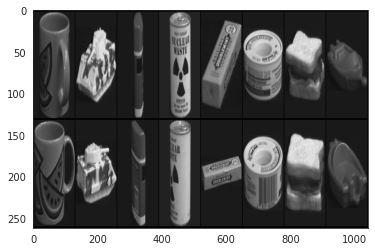

In [19]:
sns.set_style("white"); 
dataiter = iter(test_dataloader)
example_batch = next(dataiter) 
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
xx = torchvision.utils.make_grid(concatenated)
xx = xx.permute(1,2,0)
plt.imshow(xx,  aspect='auto')
a = example_batch[2].numpy()
print('Original :', a) 
b = model(example_batch[0].cuda(),example_batch[1].cuda()) 
print('predicted : ',{b})
test_loss = torch.sqrt(loss( b.cuda() , example_batch[2].cuda() )) 
print('Test_Loss : ', {test_loss})